* Imports historical stock price data using **`yfinance`** for the given tickers: `'AAPL'`, `'VOO'`, and `'DIA'`.

* Loops through each symbol in the `symbols` list.

* Uses `.history(period="68mo")` to download the **last 68 months** of daily historical data for each stock.

* Skips any stock with no data and prints a warning.

* Adds a new column `'Symbol'` to identify which stock each row belongs to.

* Stores the resulting DataFrame in a dictionary called `data_dict` with the stock symbol as the key.

* Prints the **closing prices** of each stock to check the downloaded data.


In [ ]:

import yfinance as yf

symbols = ['AAPL', 'VOO', 'DIA']
data_dict = {}

for symbol in symbols:
    data = yf.Ticker(symbol).history(period="68mo")

    if data.empty:
        print(f"{symbol} data is empty. Skipping.")
        continue

    data['Symbol'] = symbol
    data_dict[symbol] = data

    print(f"\n{symbol} Closing Prices:")
    print(data['Close'])




* Loads essential **data preprocessing and evaluation tools**:

  * `train_test_split` for splitting data into training and test sets
  * `MinMaxScaler` for scaling input features
  * `classification_report` for evaluating model performance

* Defines a custom function `compute_rsi()` to calculate the **Relative Strength Index (RSI)**:

  * Calculates price changes (`delta`)
  * Separates gains and losses
  * Applies a moving average to both
  * Computes the RSI using the formula: `100 - (100 / (1 + RS))`, where RS is the ratio of average gain to average loss
  * RSI helps detect **momentum and potential reversal points** in stock price trends


In [ ]:
# 1 Libraries for ML
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# --- RSI function ---
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

* Downloads **20 years of historical stock data** for AAPL, VOO, and DIA using `yfinance`

* Calculates **technical indicators** for each stock:

  * `MA_5`: 5-day moving average
  * `MA_10`: 10-day moving average
  * `STD_10`: 10-day rolling standard deviation
  * `Upper_Band` and `Lower_Band`: Bollinger Bands (MA ± 2 × STD)

* Creates **machine learning features**:

  * `Z_Score`: Standardized price deviation from MA
  * `RSI`: Relative Strength Index, using the previously defined function

* Generates **binary anomaly labels**:

  * Marks data points where the absolute Z-score > 2 as anomalies (1), others as normal (0)

* Stores all processed data in `data_dict`

* Uses **Plotly** to visualize:

  * Closing price
  * Moving averages
  * Bollinger Bands
  * Chart is interactive and displayed for each symbol separately


In [ ]:
# 2
import plotly.graph_objects as go

symbols = ['AAPL', 'VOO', 'DIA']
data_dict = {}

for symbol in symbols:
    data = yf.Ticker(symbol).history(period="20y", interval="1d")
    if data.empty:
        continue

    # Moving averages & Bollinger bands
    data['MA_5'] = data['Close'].rolling(window=5).mean()
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['STD_10'] = data['Close'].rolling(window=10).std()
    data['Upper_Band'] = data['MA_10'] + 2 * data['STD_10']
    data['Lower_Band'] = data['MA_10'] - 2 * data['STD_10']

    # ✅ EXTRA FEATURES for ML
    data['Z_Score'] = (data['Close'] - data['MA_10']) / data['STD_10']
    data['RSI'] = compute_rsi(data['Close'])

    # ✅ ANOMALY LABEL for ML target
    data['Anomaly'] = (data['Z_Score'].abs() > 2).astype(int)

    data_dict[symbol] = data  # save updated data

    # Chart for visualization (no change)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.index, y=data['Close'], name=f'{symbol} Close'))
    fig.add_trace(go.Scatter(x=data.index, y=data['MA_5'], name='5-Day MA', line=dict(dash='dash')))
    fig.add_trace(go.Scatter(x=data.index, y=data['MA_10'], name='10-Day MA', line=dict(dash='dot')))
    fig.add_trace(go.Scatter(x=data.index, y=data['Upper_Band'], name='Upper Bollinger Band', line=dict(dash='dot')))
    fig.add_trace(go.Scatter(x=data.index, y=data['Lower_Band'], name='Lower Bollinger Band', line=dict(dash='dot')))
    fig.update_layout(title=f'{symbol}: Price with MA and Bollinger Bands',
                      xaxis_title='Date',
                      yaxis_title='Price (USD)',
                      hovermode='x unified')
    fig.show()


Loops through each stock symbol in the symbols list.

Retrieves the related DataFrame from data_dict.

Applies a 5-day rolling mean to handle missing values (NaN).

Uses min_periods=1 to ensure early rows are also filled.

Replaces all NaN values in the DataFrame with this rolling average.

Saves the updated DataFrame back into data_dict.

Ensures data is clean and ready for feature engineering or model input.

In [ ]:
## YENI VERSIYON

for symbol in symbols:
    df = data_dict[symbol]
    df = df.fillna(df.rolling(window=5, min_periods=1).mean())
    data_dict[symbol] = df


* Iterates through each stock symbol in the `symbols` list.
* Retrieves the corresponding DataFrame from `data_dict`.
* Calculates the **Z-Score** to measure how far the current price deviates from the 10-day moving average.
* Computes the **Relative Strength Index (RSI)** using a 14-day window to assess momentum.
* Creates a new **binary label column (`Anomaly`)** where values with `|Z-Score| > 2` are marked as anomalies (`1`).
* Adds these new features (`Z_Score`, `RSI`, `Anomaly`) into the DataFrame.
* Stores the updated DataFrame back into `data_dict` for later use in machine learning models.


In [ ]:
## 3

for symbol in symbols:
    df = data_dict[symbol]

    # Extra ML features
    df['Z_Score'] = (df['Close'] - df['MA_10']) / df['STD_10']
    df['RSI'] = compute_rsi(df['Close'], period=14)

    # ✅ Create anomaly label for ML target
    df['Anomaly'] = (df['Z_Score'].abs() > 2).astype(int)

    # Save updated dataframe back to dictionary
    data_dict[symbol] = df


* Defines a **custom signal generation function** `generate_signal(z, rsi)` that takes Z-Score and RSI as input.
* Returns `'SELL'` if Z-Score is high and RSI shows overbought conditions (Z > 2 and RSI > 70).
* Returns `'BUY'` if Z is high but RSI is in a moderate range (Z > 2 and 50 < RSI ≤ 70).
* Returns `'BUY'` if Z is very low and RSI indicates oversold (Z < -2 and RSI < 30).
* Returns `'SELL'` if Z is very low and RSI is moderately low (Z < -2 and 30 ≤ RSI < 50).
* Otherwise, returns `'HOLD'`.
* Applies this function row-by-row on each DataFrame in `data_dict` to assign a **Signal** for every stock and day.
* Stores the updated DataFrame with the new `Signal` column back into `data_dict`.

In [ ]:
  ## 4 YENI VERSIYON

  def generate_signal(z, rsi):
      if z > 2 and rsi > 70:
          return 'SELL'
      elif z > 2 and 50 < rsi <= 70:
          return 'BUY'
      elif z < -2 and rsi < 30:
          return 'BUY'
      elif z < -2 and 30 <= rsi < 50:
          return 'SELL'
      else:
          return 'HOLD'

  # creating a signal for every stock
  for symbol in symbols:
      df = data_dict[symbol]
      df['Signal'] = df.apply(lambda row: generate_signal(row['Z_Score'], row['RSI']), axis=1)
      data_dict[symbol] = df


* Iterates over each stock symbol in the `symbols` list.
* Accesses the corresponding DataFrame from `data_dict`.
* Calculates an **Anomaly** label based on Z-Score:

  * Marks it as `1` (anomaly) if the absolute Z-Score is greater than 2.
  * Otherwise, marks it as `0` (normal).
* Converts the boolean condition to integer using `.astype(int)`.
* Updates the original `data_dict` with the modified DataFrame containing the new `Anomaly` column.


In [ ]:
## 5 YENI VERSIYON

for symbol in symbols:
    df = data_dict[symbol]
    df['Anomaly'] = (df['Z_Score'].abs() > 2).astype(int)
    data_dict[symbol] = df



* Loops through each stock symbol in `symbols`

* Retrieves the processed dataframe `df` from `data_dict`

* Creates an **interactive Plotly chart** for each stock

* Adds the following layers:

  * **Close price line**
  * **Anomaly points** (Z-score > 2): shown in **red markers**
  * **BUY signals**: shown as **green triangle-up** markers
  * **SELL signals**: shown as **orange triangle-down** markers

* Improves readability with:

  * Title showing the stock symbol
  * X-axis labeled as "Date"
  * Y-axis labeled as "Price (USD)"
  * Unified hover mode to compare all traces across the same date

* Displays the chart with `fig.show()` for each stock separately


In [ ]:
## 6 YENI VERSIYON


for symbol in symbols:
    df = data_dict[symbol]

    fig = go.Figure()

    # Close price + MA + Bollinger Bands (can be added)

    # Close price
    fig.add_trace(go.Scatter(x=df.index, y=df['Close'], name=f'{symbol} Close'))

    # Anomalies
    fig.add_trace(go.Scatter(
        x=df.index[df['Anomaly'] == 1],
        y=df['Close'][df['Anomaly'] == 1],
        mode='markers',
        name='Anomalies',
        marker=dict(color='red', size=8)
    ))

    # BUY
    fig.add_trace(go.Scatter(
        x=df.index[df['Signal'] == 'BUY'],
        y=df['Close'][df['Signal'] == 'BUY'],
        mode='markers',
        name='BUY',
        marker=dict(color='green', size=12, symbol='triangle-up', line=dict(color='black', width=1))
    ))

    # SELL
    fig.add_trace(go.Scatter(
        x=df.index[df['Signal'] == 'SELL'],
        y=df['Close'][df['Signal'] == 'SELL'],
        mode='markers',
        name='SELL',
        marker=dict(color='orange', size=12, symbol='triangle-down', line=dict(color='black', width=1))
    ))

    fig.update_layout(title=f'{symbol}: Signals and Anomalies',
                      xaxis_title='Date',
                      yaxis_title='Price (USD)',
                      hovermode='x unified')

    fig.show()


* Iterates over each stock in the `symbols` list

* Retrieves the corresponding DataFrame from `data_dict`

* Defines features for XGBoost:

  * `Close`, `MA_5`, `MA_10`, `Z_Score`, `RSI`
  * Fills any missing values (forward then backward)

* Defines target `y` as the `Anomaly` label

* Skips training if there are no anomalies in the target

* Splits the data into **training and test sets** (80% train, 20% test, no shuffle)

* Trains an **XGBoost classifier** with:

  * 200 trees
  * Max depth of 5
  * Learning rate 0.05
  * `scale_pos_weight=10` to handle class imbalance

* Predicts anomaly labels on the test set

* Prints a **classification report** (precision, recall, f1-score) for each stock model


In [ ]:

# 7


for symbol in symbols:
    df = data_dict[symbol].copy()

    # Features for XGBoost (flat, no sequences)
    features = ['Close', 'MA_5', 'MA_10', 'Z_Score', 'RSI']
    X = df[features].fillna(method='ffill').fillna(method='bfill')
    y = df['Anomaly'].loc[X.index]

    # Skip if no anomalies
    if y.sum() == 0:
        print(f"{symbol}: No anomalies, skipping.")
        continue

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # XGBoost model
    xgb_model = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        scale_pos_weight=10  # handle imbalance
    )
    xgb_model.fit(X_train, y_train)

    # Predictions
    y_pred = xgb_model.predict(X_test)

    print(f"\n=== {symbol} XGBoost Results ===")
    print(classification_report(y_test, y_pred))


In [ ]:
## FINAL VERSION together, without graphics - XGBoost



import pandas as pd


# --- RSI Calculation ---
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# --- Stock Symbols ---
symbols = ['AAPL', 'VOO', 'DIA']
data_dict = {}

# --- 1. Download Data & Feature Engineering ---
for symbol in symbols:
    df = yf.Ticker(symbol).history(period="20y", interval="1d")

    if df.empty:
        print(f"{symbol} has no data, skipping.")
        continue

    # Moving averages & Bollinger bands
    df['MA_5'] = df['Close'].rolling(window=5).mean()
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['STD_10'] = df['Close'].rolling(window=10).std()
    df['Upper_Band'] = df['MA_10'] + 2 * df['STD_10']
    df['Lower_Band'] = df['MA_10'] - 2 * df['STD_10']

    # Extra ML features
    df['Z_Score'] = (df['Close'] - df['MA_10']) / df['STD_10']
    df['RSI'] = compute_rsi(df['Close'])

    # Fill missing values
    df = df.fillna(df.rolling(window=5, min_periods=1).mean())

    # Create anomaly label for ML target
    df['Anomaly'] = (df['Z_Score'].abs() > 2).astype(int)

    data_dict[symbol] = df

    # --- XGBoost Feature Set ---
    features = ['Close', 'MA_5', 'MA_10', 'Z_Score', 'RSI']
    X = df[features].fillna(method='ffill').fillna(method='bfill')
    y = df['Anomaly'].loc[X.index]

    # Skip if there are no anomalies
    if y.sum() == 0:
        print(f"{symbol}: No anomalies found, skipping XGBoost training.")
        continue

    # Train/Test split (time-based, no shuffle)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # XGBoost model with class imbalance handling
    xgb_model = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        scale_pos_weight=10  # helps with anomaly imbalance
    )
    xgb_model.fit(X_train, y_train)

    # Predictions
    y_pred = xgb_model.predict(X_test)

    print(f"\n=== {symbol} XGBoost Results ===")
    print(classification_report(y_test, y_pred))


# === Signal Generation ===
y_pred_all = xgb_model.predict(X)

df['Signal'] = 'HOLD'
df.loc[y_pred_all == 1, 'Signal'] = 'SELL'

sell_indices = df.index[df['Signal'] == 'SELL']
for idx in sell_indices:
    next_idx = df.index.get_loc(idx) + 1
    if next_idx < len(df):
        df.iloc[next_idx, df.columns.get_loc('Signal')] = 'BUY'

data_dict[symbol] = df  # update dictionary with Signal


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    scale_pos_weight=10
)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))



Evaluating XGBoost model for AAPL
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       948
           1       0.95      1.00      0.98        59

    accuracy                           1.00      1007
   macro avg       0.98      1.00      0.99      1007
weighted avg       1.00      1.00      1.00      1007



/tmp/ipython-input-913116360.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



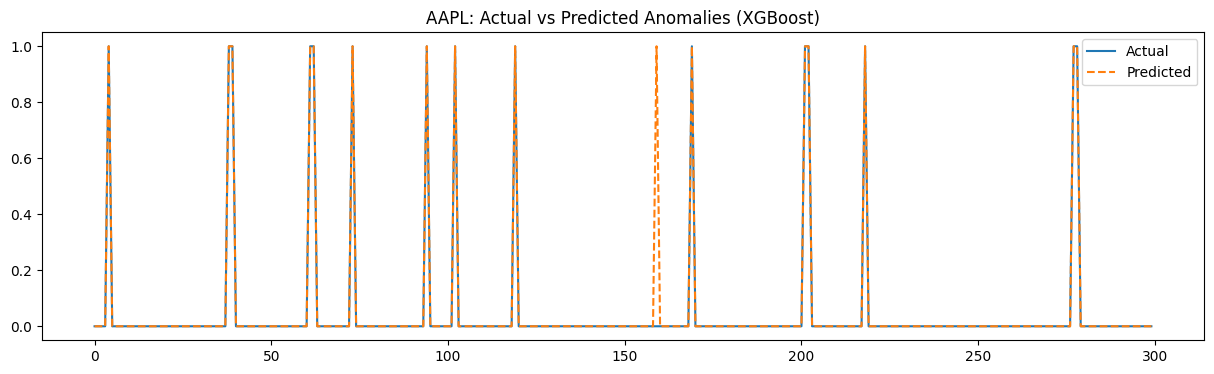


Evaluating XGBoost model for VOO
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       712
           1       1.00      1.00      1.00        41

    accuracy                           1.00       753
   macro avg       1.00      1.00      1.00       753
weighted avg       1.00      1.00      1.00       753



/tmp/ipython-input-913116360.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



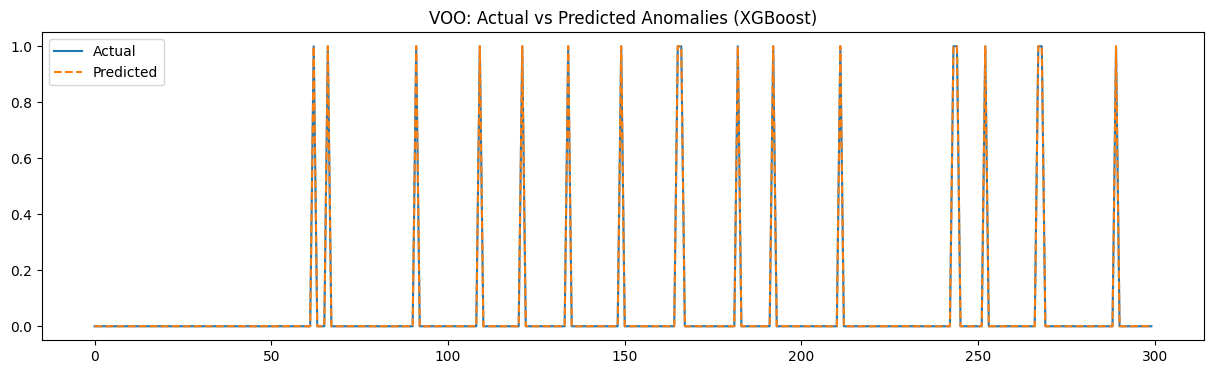


Evaluating XGBoost model for DIA
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       960
           1       0.90      1.00      0.95        47

    accuracy                           1.00      1007
   macro avg       0.95      1.00      0.97      1007
weighted avg       1.00      1.00      1.00      1007



/tmp/ipython-input-913116360.py:11: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



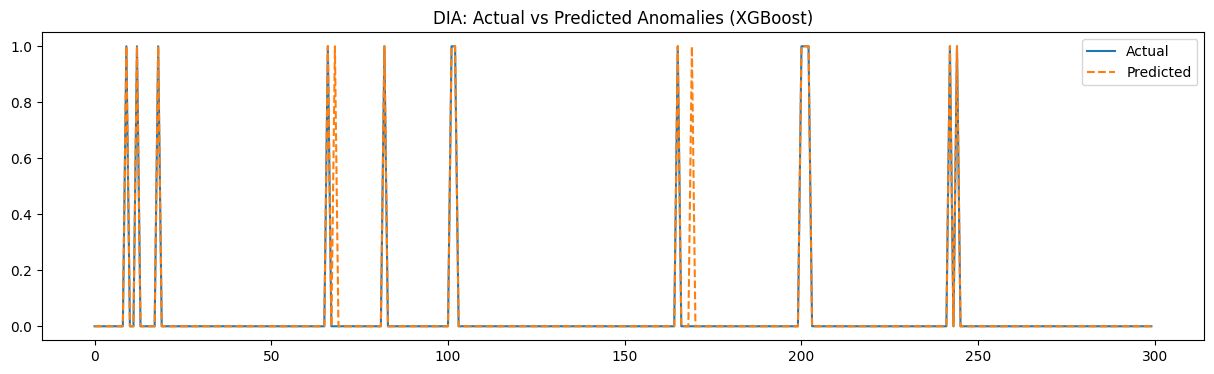

In [ ]:
# after
import matplotlib.pyplot as plt

for symbol in symbols:
    print(f"\nEvaluating XGBoost model for {symbol}")

    df = data_dict[symbol]

    # Features & labels
    features = ['Close', 'MA_5', 'MA_10', 'Z_Score', 'RSI']
    X = df[features].fillna(method='ffill').fillna(method='bfill')
    y = df['Anomaly'].loc[X.index]

    if y.sum() == 0:
        print(f"{symbol}: No anomalies found, skipping evaluation.")
        continue

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # Predict using trained XGBoost model
    y_pred = xgb_model.predict(X_test)

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Optional visualization: predicted vs actual
    plt.figure(figsize=(15, 4))
    plt.plot(y_test.reset_index(drop=True).values[:300], label='Actual')
    plt.plot(y_pred[:300], label='Predicted', linestyle='dashed')
    plt.legend()
    plt.title(f"{symbol}: Actual vs Predicted Anomalies (XGBoost)")
    plt.show()


B A C K  T E S T I N G


AAPL: Signal column not found. Skipping.
VOO: Signal column not found. Skipping.

=== DIA Backtest Results ===
Final Portfolio Value: $1444.18
Total Profit: 44.42%
Max Drawdown: 11.08%


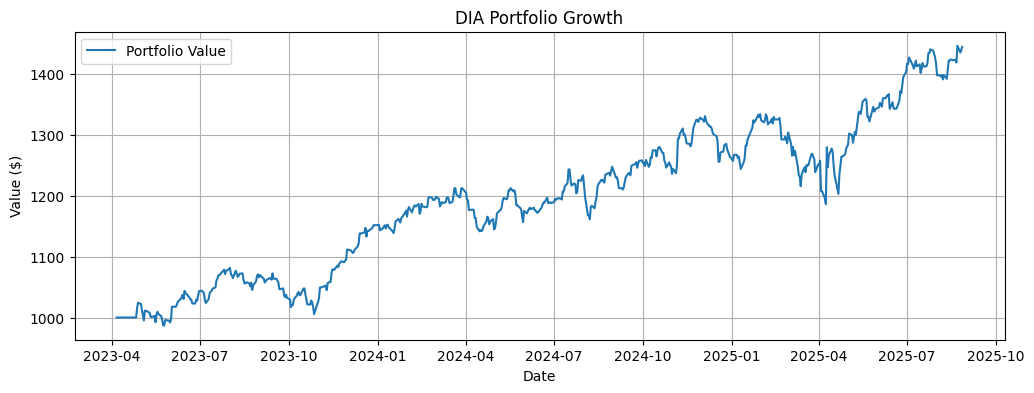

In [ ]:
initial_cash = 1000  # Başlangıç bütçesi

for symbol in symbols:
    df = data_dict[symbol].copy()

    # Son 600 günle sınırla (isteğe bağlı)
    df = df.tail(600)

    # Sinyal sütunu yoksa atla
    if 'Signal' not in df.columns:
        print(f"{symbol}: Signal column not found. Skipping.")
        continue

    cash = initial_cash
    shares = 0
    portfolio_values = []

    for i in range(len(df)):
        price = df['Close'].iloc[i]
        signal = df['Signal'].iloc[i]

        # BUY sinyali → tüm nakitle hisse al
        if signal == 'BUY' and cash > 0:
            shares = cash / price
            cash = 0

        # SELL sinyali → tüm hisseleri sat
        elif signal == 'SELL' and shares > 0:
            cash = shares * price
            shares = 0

        # Portföy değeri = nakit + eldeki hisselerin değeri
        portfolio_value = cash + shares * price
        portfolio_values.append(portfolio_value)

    df['Portfolio'] = portfolio_values
    final_value = df['Portfolio'].iloc[-1]
    profit_pct = ((final_value - initial_cash) / initial_cash) * 100
    max_drawdown = ((df['Portfolio'].cummax() - df['Portfolio']) / df['Portfolio'].cummax()).max() * 100

    print(f"\n=== {symbol} Backtest Results ===")
    print(f"Final Portfolio Value: ${final_value:.2f}")
    print(f"Total Profit: {profit_pct:.2f}%")
    print(f"Max Drawdown: {max_drawdown:.2f}%")

    # Optional: plot portfolio growth
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df['Portfolio'], label='Portfolio Value')
    plt.title(f'{symbol} Portfolio Growth')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.grid()
    plt.legend()
    plt.show()
